In [184]:
import pandas as pd
pd.set_option("display.max_rows", 150)
pd.set_option('display.max_colwidth', -1)

import numpy as np

import glob

import gpxpy
import gpxpy.gpx

import re

from IPython.display import display, HTML

import requests
import pickle

In [185]:
# functions for judging a description
not_flowing_keywords = ["dry", "no water", "no flow", "not "]
def isNotFlowing(description):
    return any([kw in description for kw in not_flowing_keywords])
assert(isNotFlowing("looks dry"))

flowing_keywords = ["good", "flowing", "flow", "lots", "working"]
def isFlowing(description):
    return any([kw in description for kw in flowing_keywords])
assert(isFlowing("flowing well"))

In [186]:
# a function that tries to fix a location id, leaves non-waypoint labels alone in case they are in the gps data
# fixes the leading zeros problem WR004 = WR0004
def clean_loc_id(id):
    try:
        waypoint_search = re.search('((?:WR|WA)(?:CS|))([0-9]+)', id, re.IGNORECASE)

        if waypoint_search:        
            waypoint_type = waypoint_search.group(1)
            waypoint_num = waypoint_search.group(2)

            return f"{waypoint_type}{int(waypoint_num):04}"
    except:
        return id
    return id
assert(clean_loc_id("WR004") == "WR0004")

In [187]:
# functions for finding the last positive result and last negative result
def last_pos(loc_id, date):
    last_pos_date = data[(data.loc_id == loc_id) & (data.status==1) & (data.date < date)].date.max()
    if type(last_pos_date) == float:
        return 1000
    return (date - last_pos_date).days
    
def last_neg(loc_id, date):
    last_neg_date = data[(data.loc_id == loc_id) & (data.status==0) & (data.date < date)].date.max()    
    if type(last_neg_date) == float:
        return 1000
    return (date - last_neg_date).days

In [188]:
# create a lat, lon, and name dictionaries keyed on loc_ids 
waypoints = []
for path in glob.glob("gps/*.gpx"):
    gpx_file = open(path, 'r')
    gpx = gpxpy.parse(gpx_file)
    waypoints += (gpx.waypoints)
    
lat = {clean_loc_id(wp.name):wp.latitude for wp in waypoints}
lon = {clean_loc_id(wp.name):wp.longitude for wp in waypoints}
name = {clean_loc_id(wp.name):wp.description for wp in waypoints}

In [251]:
waypoints

[GPXWaypoint(41.158167, -122.29788, elevation=751.0, name='KettlebellyTR', description='Kettlebelly Trail junction', symbol='Trail Head'),
 GPXWaypoint(41.164, -122.310161, elevation=764.3, name='FernSpringsTR', description='Fern Springs trail junction', symbol='Trail Head'),
 GPXWaypoint(41.16411, -122.310119, elevation=763.5, name='FernSprings', description='Fern Springs', symbol='Water Source'),
 GPXWaypoint(41.162298, -122.312262, elevation=804.3, name='RootCreekTR', description='Root Creek trail junction', symbol='Trail Head'),
 GPXWaypoint(41.161274, -122.312177, elevation=803.1, name='VistaPointTR', description='Vista Point trail junction', symbol='Trail Head'),
 GPXWaypoint(41.16018, -122.312608, elevation=814.3, name='CragsTR', description='Crags Trail junction', symbol='Trail Head'),
 GPXWaypoint(41.158052, -122.320655, elevation=861.9, name='BobsHatTR', description="Bob's Hat trail junction", symbol='Trail Head'),
 GPXWaypoint(41.162168, -122.327274, elevation=889.0, name='C

In [189]:
# a generator for sequentially reading in the data
def data_generator():
    for f in glob.glob("pct_data/*.xlsx"):
        data = pd.read_excel(f).dropna()
        _,cols = data.shape
        if cols == 7:
            data.columns = ["map","mile","loc_id","loc", "description", "date", "user"]
        if cols == 8:
            data.columns = ["map","mile_2","mile","loc_id","loc", "description", "date", "user"]
        yield data

In [190]:
# import and combine data
data = pd.concat(data_generator())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [191]:
# clean up the descriptions
data.description = data.description.str.split("\n").str[0].str.lower()

In [192]:
# clean up the lod_ids
data.loc_id = data.loc_id.apply(clean_loc_id)

In [193]:
# create a unix time column
data["unix_time"] = (pd.to_datetime(data["date"], errors='coerce').astype(np.int64)//1000000000)

In [194]:
# create lat and lon columns
data["lat"] = data["loc_id"].map(lat)
data["lon"] = data["loc_id"].map(lon)

In [272]:
# create not_flowing and flowing columns
data["not_flowing"] = data["description"].map(isNotFlowing, na_action="ignore")
data["flowing"] = data["description"].map(isFlowing, na_action="ignore")
data["decision"] = data.flowing|data.not_flowing
data["status"] = data.flowing.astype(float)

In [196]:
# remove duplicate entries (ones with the same date and loc_id)
data = data.drop_duplicates(subset=["date","loc_id"])

In [197]:
# remove all data with no decision
data = data[data.decision]

In [198]:
# create last positive and negative result columns
data["last_pos"] = data.apply(lambda row: last_pos(row.loc_id, row.date), axis=1)
data["last_neg"] = data.apply(lambda row: last_neg(row.loc_id, row.date), axis=1)

In [199]:
# drop data with missing coordinates
data = data.dropna(subset=["lat"])

In [200]:
loc_ids = list(data.groupby("loc_id").nunique().sort_values(by="date")[-50:].loc_id.index)

In [201]:
data = data[data.loc_id.isin(loc_ids)]

In [202]:
data.shape

(1124, 17)

In [209]:
try:
    f = open('rain_memo.pkl', 'rb')
    rain_memo = pickle.load(f)
    f.close()
except:
    rain_memo = {}

def getRainfall(loc_id, unix_time):
    if (loc_id, unix_time) in rain_memo:
        return rain_memo[(loc_id, unix_time)]
    r = requests.get(f"https://api.darksky.net/forecast/840fdc3fb61acc3d4e904978b5ba8dc5/{lat[loc_id]},{lon[loc_id]},{unix_time}")
    rain = r.json()["daily"]["data"][0]["precipIntensity"]
    rain_memo[(loc_id, unix_time)] = rain
    f = open('rain_memo.pkl', 'wb')
    pickle.dump(rain_memo, f)
    f.close() 
    
    return rain

In [211]:
rain_memo

{('WRCS0232', 1559520000): 0.0019,
 ('WRCS0232', 1559433600): 0.0005,
 ('WRCS0232', 1559347200): 0,
 ('WRCS0232', 1559260800): 0,
 ('WRCS0232', 1559174400): 0.0002,
 ('WRCS0232', 1528675200): 0,
 ('WRCS0232', 1528588800): 0,
 ('WRCS0232', 1528502400): 0,
 ('WRCS0232', 1528416000): 0,
 ('WRCS0232', 1528329600): 0,
 ('WRCS0232', 1539648000): 0,
 ('WRCS0232', 1539561600): 0.0001,
 ('WRCS0232', 1539475200): 0.034,
 ('WRCS0232', 1539388800): 0.0007,
 ('WRCS0232', 1539302400): 0.0001,
 ('WRCS0232', 1556236800): 0,
 ('WRCS0232', 1556150400): 0,
 ('WRCS0232', 1556064000): 0,
 ('WRCS0232', 1555977600): 0,
 ('WRCS0232', 1555891200): 0,
 ('WRCS0232', 1554854400): 0,
 ('WRCS0232', 1554768000): 0,
 ('WRCS0232', 1554681600): 0,
 ('WRCS0232', 1554595200): 0.0001,
 ('WRCS0232', 1554508800): 0,
 ('WRCS0232', 1524182400): 0,
 ('WRCS0232', 1524096000): 0,
 ('WRCS0232', 1524009600): 0,
 ('WRCS0232', 1523923200): 0,
 ('WRCS0232', 1523836800): 0,
 ('WRCS0232', 1526428800): 0,
 ('WRCS0232', 1526342400): 0,
 

In [204]:
def getRainSum(loc_id, unix_time, n):
    return 24 * sum([getRainfall(loc_id, unix_time - (24*60*60*day)) for day in range(n)])

In [210]:
data["rain_5"] = data.apply(lambda row: getRainSum(row.loc_id, row.unix_time, 5), axis=1)

In [274]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split

import time

from matplotlib import cm

In [207]:


out = []
for loc_id in loc_ids:
    inputs = data[data.loc_id == loc_id][["rain_5","last_pos","last_neg"]]
    labels = data[data.loc_id == loc_id]['status']
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0)

    lr = LogisticRegression(C=100, penalty="l1", class_weight="balanced").fit(X_train, y_train)
    svc = SVC(probability=True).fit(X_train, y_train)
    br = BayesianRidge().fit(X_train, y_train)
    rf = RandomForestClassifier().fit(inputs, labels)

    dummy = DummyClassifier().fit(X_train, y_train)
    dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
    
    print(f'Training score {lr.score(X_train, y_train)}')
    print(f'Training score {svc.score(X_train, y_train)}')
    print(f'Training score {rf.score(X_train, y_train)}')


    print()
    print(f'Test score {lr.score(X_test, y_test)}')
    print(f'Test score {svc.score(X_test, y_test)}')
    print(f'Test score {rf.score(X_test, y_test)}')
    print(f'Dummy score {dummy.score(X_test, y_test)}')
    print(f'Most Frequent score {dummy_majority.score(X_test, y_test)}')
    
    prediction = rf.predict_proba([getRainSum(loc_id, int(time.time()), 5), ])
    out.append({'lat': lat[loc_id], 'lon': lon[loc_id], 'name': name[loc_id], 'prediction':prediction})

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0

In [212]:


inputs = data[["rain_5","last_pos","last_neg"]]
labels = data['status']
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0)

lr = LogisticRegression(C=100, penalty="l1", class_weight="balanced").fit(X_train, y_train)
svc = SVC(probability=True).fit(X_train, y_train)
br = BayesianRidge().fit(X_train, y_train)
rf = RandomForestClassifier().fit(inputs, labels)

dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

print(f'Training score {lr.score(X_train, y_train)}')
print(f'Training score {svc.score(X_train, y_train)}')
print(f'Training score {rf.score(X_train, y_train)}')


print()
print(f'Test score {lr.score(X_test, y_test)}')
print(f'Test score {svc.score(X_test, y_test)}')
print(f'Test score {rf.score(X_test, y_test)}')
print(f'Dummy score {dummy.score(X_test, y_test)}')
print(f'Most Frequent score {dummy_majority.score(X_test, y_test)}')
    


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training score 0.6702253855278766
Training score 0.9644128113879004
Training score 0.970344009489917

Test score 0.6334519572953736
Test score 0.8647686832740213
Test score 0.99644128113879
Dummy score 0.7544483985765125
Most Frequent score 0.8718861209964412


In [248]:
out = []
for loc_id in loc_ids:
    now = pd.Timestamp.now().round('1d')
    prediction = rf.predict_proba([[getRainSum(loc_id, int(now.value/10**9), 5), last_pos(loc_id, now), last_neg(loc_id, now)]])
    out.append({'lat': lat[loc_id], 'lon': lon[loc_id], 'name': name[loc_id], 'prediction':prediction[0][1]})

In [250]:
f = open('out.pkl', 'wb')
pickle.dump(out, f)
f.close() 

In [252]:
out

[{'lat': 34.27535,
  'lon': -117.049934,
  'name': 'Large creek',
  'prediction': 0.90000000000000002},
 {'lat': 34.298685,
  'lon': -117.384568,
  'name': 'Small seasonal stream',
  'prediction': 0.40000000000000002},
 {'lat': 35.434233,
  'lon': -118.309612,
  'name': 'Landers Creek, often dry.',
  'prediction': 0.40000000000000002},
 {'lat': 34.013162,
  'lon': -116.669843,
  'name': 'Whitewater Creek',
  'prediction': 1.0},
 {'lat': 34.050904,
  'lon': -116.670839,
  'name': 'Mission Creek Crossing',
  'prediction': 0.80000000000000004},
 {'lat': 34.097104,
  'lon': -116.67934,
  'name': 'Campsite near Mission Creek',
  'prediction': 0.80000000000000004},
 {'lat': 34.09092,
  'lon': -116.673008,
  'name': 'Campsite near Mission Creek',
  'prediction': 0.80000000000000004},
 {'lat': 33.035761,
  'lon': -116.536292,
  'name': 'Seasonal Chariot Canyon Spring, 1.4 miles N of PCT, spring is on the W side of the road hidden from view by several large oak trees.',
  'prediction': 0.599999

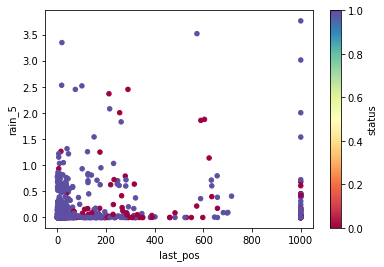

In [276]:
data.plot(kind='scatter',x="last_pos",y="rain_5",c="status", cmap=cm.get_cmap('Spectral'))

,date,description,loc,loc_id,map,mile,mile_2,user,unix_time,lat,lon,not_flowing,flowing,decision,status,last_pos,last_neg,rain_5
10,2018-02-17 00:00:00,flowing pretty good.,Creeklet [early spring only]\nBeware of poison oak here.,WR0004,A1,4.4,NaN,Trixie,1518825600,32.608000,-116.498991,False,True,True,1,18,999,0.0624
13,2018-01-30 00:00:00,dry,Hauser Creek [early spring only],WRCS0015,A2,15.4,NaN,Warner Springs Monty,1517270400,32.661418,-116.545505,True,False,True,0,236,6,0.0000
17,2018-02-03 00:00:00,dry,Cottonwood Creek Bridge,WR0024,A3,24.1,NaN,Warner Springs Monty,1517616000,32.715239,-116.499008,True,False,True,0,281,24,0.0000
18,2018-02-03 00:00:00,2/3/18 (warner springs monty) : flowing. crossed on a log.,Cottonwood Creekbed,WR0026,A3,25.5,NaN,Warner Springs Monty,1517616000,32.729263,-116.490416,False,True,True,1,8,500,0.0000
23,2018-02-03 00:00:00,lots of water.,*Kitchen Creek Falls [2/10 mi NW],KitchenCrFalls,A3,28.5,NaN,Warner Springs Monty,1517616000,32.742984,-116.464639,False,True,True,1,239,126,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,2018-05-09 00:00:00,5/9/18 (cloud rider) : 1 liter / 30 seconds flow of cold clear water. very shallow and hard to collect without getting dirt.,*Fountainhead Spring,WR0411,D7,411,NaN,Cloud Rider,1525824000,34.380726,-118.027200,False,True,True,1,5,1000,0.0000
33,2018-03-12 00:00:00,3/12/18 (don) : fair flow/clear.,*Long Canyon Creek ford,WR0038,A5,37.7,NaN,Don,1520812800,32.819298,-116.414038,False,True,True,1,6,1000,0.8352
58,2018-03-13 00:00:00,3/13/18 (nick) : working great.,**Rodriguez Spur Truck Tr\n[Concrete fire tank visible 75 ft W]\n\n-\nWe are especially interested in water reports about this location. Please send info.,WRCS0068,A9,68.4,NaN,Nick,1520899200,33.050184,-116.524317,False,True,True,1,4,36,0.8232
85,2018-03-11 00:00:00,3/11/18 (unnamed) : excellent flow.,Agua Caliente Creek\n[near picnic tables],WR0113,B1,112.6,NaN,Unnamed,1520726400,33.295565,-116.638654,False,True,True,1,2,85,0.5832
